In [1]:
# Import Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#modeling tools
import statsmodels.api as sm

import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, auc, roc_auc_score, roc_curve, log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

%matplotlib inline
plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

pd.set_option('display.min_row', 15)
pd.set_option('display.max_column', 100)
pd.set_option('display.max_colwidth', 300)

In [2]:
collisions = pd.read_csv('../data/Collisions.csv')
clean_data = pd.read_pickle('../data/processed/cleaned_data.pkl')
intersection_n = pd.read_pickle('../data/processed/intersection_w_normalization.pkl')

crosswalks = pd.read_csv('../data/Marked_Crosswalks.csv')
circles = pd.read_csv('../data/Traffic_Circles.csv')
intersections = pd.read_csv('../data/Intersections.csv')

In [3]:
collisions['INJURED_OHE'] = collisions['INJURIES'].apply(lambda x: 1 if x > 0 else 0)

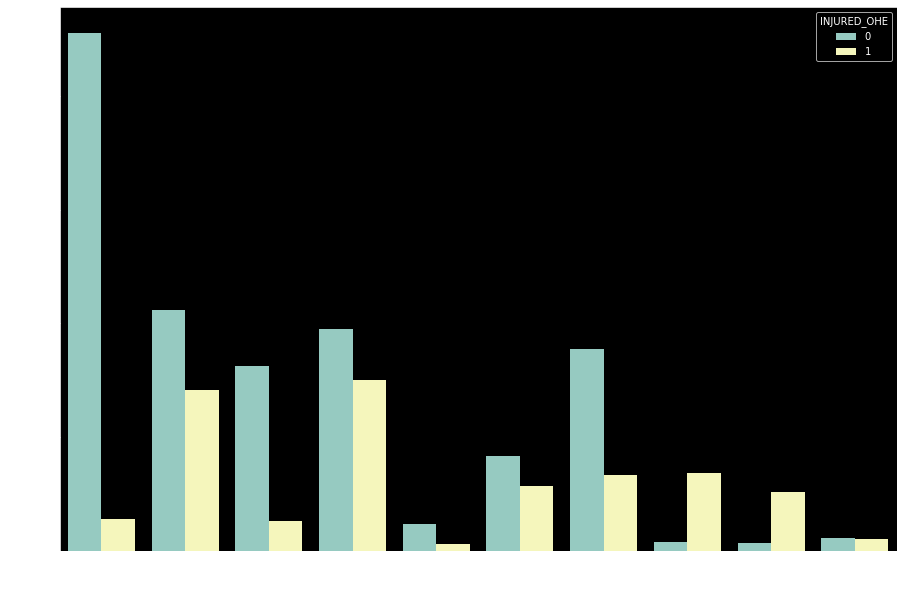

In [4]:
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.countplot('COLLISIONTYPE', data=collisions, hue='INJURED_OHE');

In [5]:
print( 'Percent not injured: ', round((collisions['INJURED_OHE'] == 0).sum() / len(collisions['INJURED_OHE'])*100 , 3) )
print( 'Percent injured: ', round((collisions['INJURED_OHE'] != 0).sum() / len(collisions['INJURED_OHE'])*100 , 3) )

Percent not injured:  72.028
Percent injured:  27.972


## Traffic Circles

In [6]:
# no null values
circles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X                          1066 non-null   float64
 1   Y                          1066 non-null   float64
 2   OBJECTID                   1066 non-null   int64  
 3   COMPKEY                    1066 non-null   int64  
 4   UNITID                     1066 non-null   object 
 5   UNITDESC                   1066 non-null   object 
 6   CONDITION                  1066 non-null   object 
 7   CONDITION_ASSESSMENT_DATE  1066 non-null   object 
 8   CURRENT_STATUS             1066 non-null   object 
 9   OWNERSHIP                  1066 non-null   object 
 10  PRIMARYDISTRICTCD          1066 non-null   object 
 11  SECONDARYDISTRICTCD        1066 non-null   object 
 12  COMPTYPE                   1066 non-null   int64  
 13  CURRENT_STATUS_DATE        1066 non-null   objec

In [7]:
circles.head(2)

,X,Y,OBJECTID,COMPKEY,UNITID,UNITDESC,CONDITION,CONDITION_ASSESSMENT_DATE,CURRENT_STATUS,OWNERSHIP,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,COMPTYPE,CURRENT_STATUS_DATE,INSTALL_DATE,INSTALL_PURPOSE,INTKEY,LANDSCAPING,MAINTAINED_BY,MAINTENANCE_AGREEMENT,NO_LAND_REASON,OVERRIDECOMMENT,OVERRIDEYN,OWNERSHIP_DATE,SDOT_INITIATED,SEWER_ACCESS_COVER,TRCSIZE,SURVEY_MONUMENT,TRCSHAPE,UNITTYPE,SHAPE_LNG,SHAPE_LAT
0,1.258588e+06,210475.502412,1,509338,TRC-601,38TH AVE SW AND SW DAKOTA ST,GOOD,2009/09/15 00:00:00+00,INSVC,SDOT,DISTRICT1,,16,2009/10/14 00:00:00+00,2000/05/16 00:00:00+00,,31889,Y,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.380088,47.566489
1,1.266983e+06,260074.185342,2,509566,TRC-934,FREMONT AVE N AND N 102ND ST,GOOD,2009/09/09 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1996/01/02 00:00:00+00,,37392,Y,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.350050,47.702894


In [8]:
circles['INTKEY'].unique()

array([31889, 37392, 24389, ..., 37927, 36735, 27847])

In [9]:
# collisions that happened at a traffic circle, even small ones (confirmed on google maps): 1613
# some traffic circles had more, so about 640 traffic circles make up the 1613 accidents

circle_accidents = clean_data[clean_data['INTKEY'].isin(np.intersect1d(clean_data['INTKEY'].unique(), circles['INTKEY'].unique()))].copy()

In [232]:
circle_accidents['collision'] = np.ones((circle_accidents.shape[0], 1))

In [233]:
circle_acc = circle_accidents[['INTKEY', 'collision']].groupby('INTKEY').count().reset_index()

In [234]:
circles_collisions = circles.merge(circle_acc, how='left', on='INTKEY')

In [235]:
# found duplicates in the circles data
# drop duplicates as it has no value
circles_collisions[circles_collisions['INTKEY'] == 36723]

,X,Y,OBJECTID,COMPKEY,UNITID,UNITDESC,CONDITION,CONDITION_ASSESSMENT_DATE,CURRENT_STATUS,OWNERSHIP,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,COMPTYPE,CURRENT_STATUS_DATE,INSTALL_DATE,INSTALL_PURPOSE,INTKEY,LANDSCAPING,MAINTAINED_BY,MAINTENANCE_AGREEMENT,NO_LAND_REASON,OVERRIDECOMMENT,OVERRIDEYN,OWNERSHIP_DATE,SDOT_INITIATED,SEWER_ACCESS_COVER,TRCSIZE,SURVEY_MONUMENT,TRCSHAPE,UNITTYPE,SHAPE_LNG,SHAPE_LAT,collision
165,1.276636e+06,263925.690434,166,509817,TRC-203,16TH AVE NE AND NE 117TH ST,GOOD,2009/09/14 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1997/09/19 00:00:00+00,,36723,N,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.311155,47.713966,4.0
166,1.276636e+06,263925.690434,167,509818,TRC-202,16TH AVE NE AND NE 117TH ST,GOOD,2009/07/06 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1983/07/15 00:00:00+00,,36723,Y,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.311155,47.713966,4.0


In [236]:
circles_collisions.drop_duplicates(subset='INTKEY', inplace=True)

In [237]:
# about 56.16% of traffic circles have had accidents within 2004-2020, 16 year periods

print('Percent of intersections with incidents: ',
      round((~circles_collisions['collision'].isnull()).sum() / (len(circles_collisions['collision']))*100 , 2),'%')

Percent of intersections with incidents:  56.16 %


In [238]:
circles_collisions.isnull().sum()

X                               0
Y                               0
OBJECTID                        0
COMPKEY                         0
UNITID                          0
UNITDESC                        0
CONDITION                       0
CONDITION_ASSESSMENT_DATE       0
CURRENT_STATUS                  0
OWNERSHIP                       0
PRIMARYDISTRICTCD               0
SECONDARYDISTRICTCD             0
COMPTYPE                        0
CURRENT_STATUS_DATE             0
INSTALL_DATE                    0
INSTALL_PURPOSE                 0
INTKEY                          0
LANDSCAPING                     0
MAINTAINED_BY                   0
MAINTENANCE_AGREEMENT        1056
NO_LAND_REASON                  0
OVERRIDECOMMENT              1056
OVERRIDEYN                      0
OWNERSHIP_DATE                  0
SDOT_INITIATED                  0
SEWER_ACCESS_COVER              0
TRCSIZE                         0
SURVEY_MONUMENT                 0
TRCSHAPE                        0
UNITTYPE      

In [239]:
# Drop the columns with all missing values and fill collisions with 0 for not having collisions

circles_collisions['collision'].fillna('0', inplace=True)
circles_collisions.drop(columns=['MAINTENANCE_AGREEMENT', 'OVERRIDECOMMENT'], inplace=True)

In [240]:
# for some reason, collision column is object type. change to int

circles_collisions['collision'] = circles_collisions['collision'].astype(int)

## EDA and OHE

In [241]:
circles_collisions.head()

,X,Y,OBJECTID,COMPKEY,UNITID,UNITDESC,CONDITION,CONDITION_ASSESSMENT_DATE,CURRENT_STATUS,OWNERSHIP,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,COMPTYPE,CURRENT_STATUS_DATE,INSTALL_DATE,INSTALL_PURPOSE,INTKEY,LANDSCAPING,MAINTAINED_BY,NO_LAND_REASON,OVERRIDEYN,OWNERSHIP_DATE,SDOT_INITIATED,SEWER_ACCESS_COVER,TRCSIZE,SURVEY_MONUMENT,TRCSHAPE,UNITTYPE,SHAPE_LNG,SHAPE_LAT,collision
0,1.258588e+06,210475.502412,1,509338,TRC-601,38TH AVE SW AND SW DAKOTA ST,GOOD,2009/09/15 00:00:00+00,INSVC,SDOT,DISTRICT1,,16,2009/10/14 00:00:00+00,2000/05/16 00:00:00+00,,31889,Y,SDOT,,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.380088,47.566489,2
1,1.266983e+06,260074.185342,2,509566,TRC-934,FREMONT AVE N AND N 102ND ST,GOOD,2009/09/09 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1996/01/02 00:00:00+00,,37392,Y,SDOT,,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.350050,47.702894,3
2,1.274207e+06,254314.130296,3,508937,TRC-784,8TH AVE NE AND NE 81ST ST,GOOD,2009/08/03 00:00:00+00,INSVC,SDOT,DISTRICT4,,16,2009/10/14 00:00:00+00,1991/03/20 00:00:00+00,,24389,Y,SDOT,,N,1970/01/01 00:00:00+00,N,N,16,N,CRC,TRC,-122.320263,47.687493,1
3,1.278437e+06,217535.101459,4,509329,TRC-422,25TH AVE S AND S GRAND ST,GOOD,2009/09/21 00:00:00+00,INSVC,SDOT,DISTRICT3,,16,2009/10/14 00:00:00+00,2003/02/10 00:00:00+00,,31416,Y,SDOT,,N,1970/01/01 00:00:00+00,N,N,0,N,OTHER,TRC,-122.300247,47.586905,2
4,1.280848e+06,255438.451194,5,509639,TRC-542,32ND AVE NE AND NE 86TH ST,GOOD,2009/09/15 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1999/06/29 00:00:00+00,,37684,Y,SDOT,,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.293392,47.690923,0


- X and Y is not the actual coordinates. *drop*
- OBJECTID not needed, there are 2 other unique identifiers. *drop*
- COMPKEY is all unique. could be different matches than INTKEY
- UNITID is simply another identifier. *drop*
- CONDITION has 4 values, one is nothing, check those 2 row out.
- CONDITION_ASSESSMENT_DATE can be dropped since there is another. *drop*
- CURRENT_STATUS and OWNERSHIP can be dropped, only one value. *drop*
- PRIMARYDISTRICTCD can be OHE, could be useful for separating by area
- SECONDARYDISTRICTCD can be dropped, basically all missing. *drop*
- COMPTYPE can be dropped, all the same. intersections have different types? circles is 16? *drop*
- CURRENT_STATUS_DATE use to extract year, month, day then drop
- INSTALL_DATE can be taken for its year just to see how many are built and when
- INSTALL_PURPOSE has way too much missing. however, check out rows with 'SAFETY'
    - all with 'SAFETY' and 'CALMING' has basically all had accidents. But then again, most traffic circles do (about 56%)
- INTKEY needs for merging with intersections
- LANDSCAPING, SDOT_INITIATED, SEWER_ACCESS_COVER, TRCSIZE, SURVEY_MONUMENT is very imbalanced but has only 2 values
    - SDOT_INITIATED and SEWER_ACCESS_COVER can be dropped
    - deeper look into LANDSCAPING, TRCSIZE and SURVEY_MONUMENT before dropping
- MAINTAINED_BY, NO_LAND_REASON, OVERRIDEYN, OWNERSHIP_DATE *drop*
- TRCSHAPE has 4 values, 1 empty. can make into circle vs non-circle
- UNITTYPE only 1 value. *drop*
- SHAPE_LNG and SHAPE_LAT can be used for very precise merging

In [242]:
to_drop = ['X', 'Y', 'OBJECTID', 'UNITID', 'CONDITION_ASSESSMENT_DATE', 'CURRENT_STATUS', 'OWNERSHIP', 'SECONDARYDISTRICTCD', 'COMPTYPE',
          'INSTALL_PURPOSE', 'SDOT_INITIATED', 'SEWER_ACCESS_COVER',
          'MAINTAINED_BY', 'NO_LAND_REASON', 'OVERRIDEYN', 'OWNERSHIP_DATE', 'UNITTYPE'
          ]

circles_collisions.drop(columns=to_drop, inplace=True)

# lowercase all column names

circles_collisions.columns = circles_collisions.columns.map(str.lower)

In [243]:
circles_collisions.head(2)

,compkey,unitdesc,condition,primarydistrictcd,current_status_date,install_date,intkey,landscaping,trcsize,survey_monument,trcshape,shape_lng,shape_lat,collision
0,509338,38TH AVE SW AND SW DAKOTA ST,GOOD,DISTRICT1,2009/10/14 00:00:00+00,2000/05/16 00:00:00+00,31889,Y,0,N,CRC,-122.380088,47.566489,2
1,509566,FREMONT AVE N AND N 102ND ST,GOOD,DISTRICT5,2009/10/14 00:00:00+00,1996/01/02 00:00:00+00,37392,Y,0,N,CRC,-122.350050,47.702894,3


### Extract dates

In [244]:
# change to datetime first for easy extraction
circles_collisions[['current_status_date', 'install_date']] = circles_collisions[['current_status_date', 'install_date']].apply(pd.to_datetime)

In [245]:
circles_collisions['year'] = circles_collisions['current_status_date'].apply(lambda x: x.year)
circles_collisions['month'] = circles_collisions['current_status_date'].apply(lambda x: x.month)
circles_collisions['day'] = circles_collisions['current_status_date'].apply(lambda x: x.day)

circles_collisions['installed'] = circles_collisions['install_date'].apply(lambda x: x.year)

In [246]:
# drop the install_date and current_status_date column

circles_collisions.drop(columns=['current_status_date', 'install_date'], inplace=True)

### Encode binary columns

In [247]:
circles_collisions[['landscaping', 'survey_monument']] = (circles_collisions[['landscaping', 'survey_monument']] == 'Y').astype(int)

### Check column with empty value (but not NaN)

In [248]:
circles_collisions[circles_collisions['trcshape'] == ' ']

,compkey,unitdesc,condition,primarydistrictcd,intkey,landscaping,trcsize,survey_monument,trcshape,shape_lng,shape_lat,collision,year,month,day,installed
185,579134,PHINNEY AVE N AND N 115TH ST,GOOD,DISTRICT5,36387,0,10,0,,-122.354183,47.712342,2,2012,11,1,1970
427,505456,PALATINE AVE N AND N 117TH ST,GOOD,DISTRICT5,36231,1,16,0,,-122.356859,47.714164,3,2019,1,3,2009


In [249]:
# can fill trcshape based on majority shape built in same year
# in 1970, most are circles
# in 2009, most are circles but can check by district. most are circles in 2009, district 5

circles_collisions['trcshape'] = circles_collisions['trcshape'].apply(lambda x: 'CRC' if x == ' ' else x)

In [250]:
circles_collisions[circles_collisions['condition'] == ' ']

,compkey,unitdesc,condition,primarydistrictcd,intkey,landscaping,trcsize,survey_monument,trcshape,shape_lng,shape_lat,collision,year,month,day,installed
462,646852,29TH AVE SW AND SW HENDERSON ST,,DISTRICT1,34944,0,26,1,OVAL,-122.369941,47.522856,13,1970,1,1,1970
982,728814,33RD AVE S AND S MORGAN ST,,DISTRICT2,34519,1,13,0,OVAL,-122.290305,47.544341,8,1970,1,1,1970


In [251]:
# can fill condition based on majority checked in year and installed in same year
# all district installed and current_status_date in 1970 is in good condition

circles_collisions['condition'] = circles_collisions['condition'].apply(lambda x: 'GOOD' if x == ' ' else x)

In [252]:
circles_collisions.head()

,compkey,unitdesc,condition,primarydistrictcd,intkey,landscaping,trcsize,survey_monument,trcshape,shape_lng,shape_lat,collision,year,month,day,installed
0,509338,38TH AVE SW AND SW DAKOTA ST,GOOD,DISTRICT1,31889,1,0,0,CRC,-122.380088,47.566489,2,2009,10,14,2000
1,509566,FREMONT AVE N AND N 102ND ST,GOOD,DISTRICT5,37392,1,0,0,CRC,-122.350050,47.702894,3,2009,10,14,1996
2,508937,8TH AVE NE AND NE 81ST ST,GOOD,DISTRICT4,24389,1,16,0,CRC,-122.320263,47.687493,1,2009,10,14,1991
3,509329,25TH AVE S AND S GRAND ST,GOOD,DISTRICT3,31416,1,0,0,OTHER,-122.300247,47.586905,2,2009,10,14,2003
4,509639,32ND AVE NE AND NE 86TH ST,GOOD,DISTRICT5,37684,1,0,0,CRC,-122.293392,47.690923,0,2009,10,14,1999


In [265]:
# realize that the current status date values dont really matter, they are mainly checked on the same day same year. drop all.

circles_collisions.drop(columns=['year', 'month', 'day'], inplace=True)

In [285]:
circles_collisions.columns

Index(['compkey', 'unitdesc', 'condition', 'primarydistrictcd', 'intkey',
       'landscaping', 'trcsize', 'survey_monument', 'trcshape', 'shape_lng',
       'shape_lat', 'collision', 'installed'],
      dtype='object')

In [286]:
# reorder columns

circles_collisions = circles_collisions[['compkey', 'intkey', 'shape_lat', 'shape_lng', 'unitdesc',
                                         'primarydistrictcd',  'installed', 'landscaping', 'survey_monument', 
                                         'trcsize', 'trcshape', 'condition', 'collision']]

In [288]:
circles_collisions.to_csv('../data/processed/circles_collisions.csv')

## EDA: Useful Columns

In [289]:
# decide which columns aren't useful

circles_collisions.columns

Index(['compkey', 'intkey', 'shape_lat', 'shape_lng', 'unitdesc',
       'primarydistrictcd', 'installed', 'landscaping', 'survey_monument',
       'trcsize', 'trcshape', 'condition', 'collision'],
      dtype='object')

In [290]:
eliminate = ['compkey', 'unitdesc', 'intkey', 'shape_lng', 'shape_lat']

data = circles_collisions.drop(columns=eliminate).copy()

In [291]:
data.head()

,primarydistrictcd,installed,landscaping,survey_monument,trcsize,trcshape,condition,collision
0,DISTRICT1,2000,1,0,0,CRC,GOOD,2
1,DISTRICT5,1996,1,0,0,CRC,GOOD,3
2,DISTRICT4,1991,1,0,16,CRC,GOOD,1
3,DISTRICT3,2003,1,0,0,OTHER,GOOD,2
4,DISTRICT5,1999,1,0,0,CRC,GOOD,0


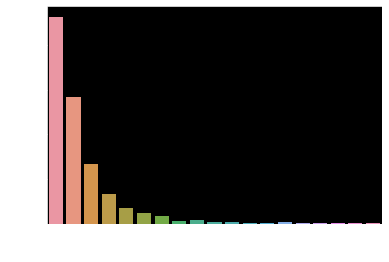

In [292]:
sns.countplot(data['collision'])

In [298]:
data.groupby('primarydistrictcd').count()

,installed,landscaping,survey_monument,trcsize,trcshape,condition,collision
primarydistrictcd,,,,,,,
DISTRICT1,107,107,107,107,107,107,107
DISTRICT2,116,116,116,116,116,116,116
DISTRICT3,196,196,196,196,196,196,196
DISTRICT4,147,147,147,147,147,147,147
DISTRICT5,219,219,219,219,219,219,219
DISTRICT6,225,225,225,225,225,225,225
DISTRICT7,46,46,46,46,46,46,46
